In [140]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

<AxesSubplot:>

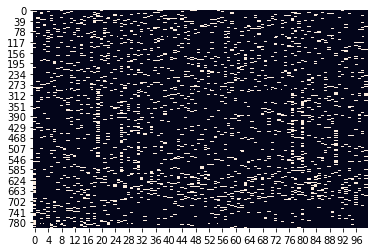

In [141]:
n_neurons = 800
t_max = 2500
n_populations = 8
permute = True
time_shifts = [0, 0, 0, 0, 0, 0, 1, 2, 3]
neuron_population_correlation = [0, .4, .4, .4, .4, .4, .9, .9, .9]
population_correlations = [0, .8, .8, .8, .8, .8, .9, .9, .9]
mean_firing_rate = 0.1

n_neurons_pop = int(n_neurons / n_populations)

spikes = np.zeros((n_neurons, t_max))

# population 1 - 3: uncorrelated
spikes[:n_neurons_pop*3, :] = np.random.poisson(lam=mean_firing_rate, size=(n_neurons_pop*3, t_max))

# population 4 - 6: correlated
corr = .3
poisson_mother_train = np.random.poisson(lam=mean_firing_rate, size=(1, t_max))

delete_spikes = corr * np.ones((3*n_neurons_pop, t_max)) <= \
                np.random.uniform(0, 1, size=(3*n_neurons_pop, t_max))
noise = np.random.poisson((1 - corr) * mean_firing_rate, (3*n_neurons_pop, t_max))
spikes[3*n_neurons_pop:6*n_neurons_pop, :] = np.tile(poisson_mother_train, (3*n_neurons_pop, 1))
spikes[3*n_neurons_pop:6*n_neurons_pop, :] = spikes[3*n_neurons_pop:6*n_neurons_pop, :] - (delete_spikes * spikes[3*n_neurons_pop:6*n_neurons_pop, :]) + noise

    
# population 7 and 8: binary network    
N_neurons = 200
weights = create_weights_binary_network(N=N_neurons, phigh=2.2, ilow=-2.5)/N_neurons
Tmax = t_max
spikes[6*n_neurons_pop:, 0] = np.random.choice([0, 1],size=(N_neurons))

for t in range(1,Tmax):
    spikes[6*n_neurons_pop:,t] = np.random.random(N_neurons) < (spikes[6*n_neurons_pop:,t-1]@weights + np.random.uniform(0,0.2,size=N_neurons))
    


# make binary
spikes[spikes < 0] = 0
spikes[spikes > 1] = 1

# create 2 dimensional brain-space locations for all neuron populations
mean_locations_pop = [[-1, 1], [0, 1], [1, 1], [-1, 0], [0, 0], [1, 0], [-.5, -1], [.5, -1]]
neuron_coordinates = np.zeros((n_neurons, 2))
for i in range(n_populations):
    neuron_coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.25 * np.random.randn(n_neurons_pop, 2) + \
                                                                       mean_locations_pop[i]


populations_idx = np.arange(n_neurons, dtype=int)
data = torch.tensor(spikes, dtype=torch.float)
sns.heatmap(data[:, :100], cbar=False)

In [72]:
data_batches = torch.zeros(160, 50, 100)
for i in range(100):
    data_batches[:, :, i] = data[:, i*50:(i+1)*50]

In [143]:
N_H = 8
rtrbm = RTRBM(data, N_H=N_H, device='cuda')
rtrbm.learn(n_epochs=1000, batchsize=1, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:18<00:00,  2.01it/s]


In [144]:
# parameters
chain = 50
pre_gibbs_k = 0
gibbs_k = 1
MC_chains = 300

for MC_chain in tqdm(range(MC_chains)):
    
    # take a random training configuration
    random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))])
    
    vs_rtrbm, hs_rtrbm = rtrbm.sample(random_train_config.T.to('cuda'), chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=2, disable_tqdm=True)
    
    # catenate all samples
    if MC_chain == 0:
        v_rtrbm = vs_rtrbm.detach().cpu()
        h_rtrbm = hs_rtrbm.detach().cpu()

    else:
        v_rtrbm = torch.cat((v_rtrbm, vs_rtrbm.cpu()), 1)
        h_rtrbm = torch.cat((h_rtrbm, hs_rtrbm.cpu()), 1)
        
H_data_rtrbm = rtrbm.visible_to_expected_hidden(data.to('cuda'), AF=torch.sigmoid)




  0%|                                                                                          | 0/300 [00:00<?, ?it/s]<ipython-input-144-bce66e809a76>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))])
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 28.99it/s]


<AxesSubplot:>

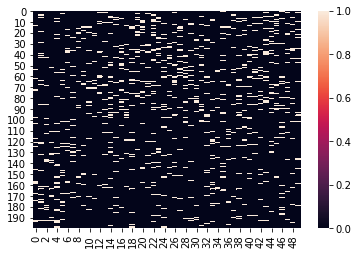

In [153]:
sns.heatmap(v_rtrbm[600:,:50].cpu())

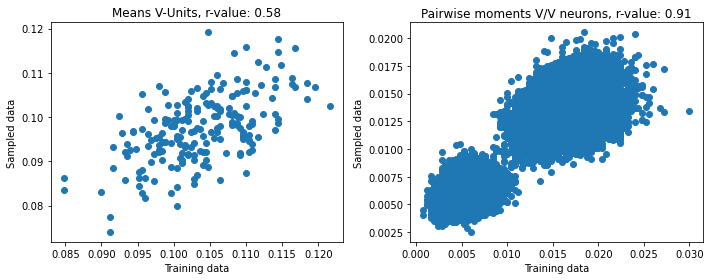

In [150]:
# RTRBM Moments of population 7-9
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data[600:, :], H_data_rtrbm.cpu(), v_rtrbm[600:, :], h_rtrbm)

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# mean visible activations rbm
ax = axes[0]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rbm
ax = axes[1]
ax.scatter(pw_VV_data, pw_VV_samples)
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons, r-value: {:.2f}".format(r_VV))


fig.tight_layout()
plt.show()

<AxesSubplot:>

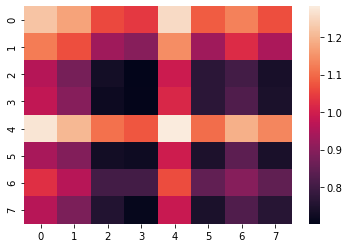

In [96]:
# parameters
chain = 50
pre_gibbs_k = 10
gibbs_k = 20
MC_chains = 300




for MC_chain in tqdm(range(MC_chains)):
    
    # take a random training configuration
    random_train_config = torch.tensor(data[:, torch.randint(0, data.shape[1], (1,))])
    vs_rbm, hs_rbm = rbm.sample(random_train_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=2, disable_tqdm=True)
    vs_rtrbm, hs_rtrbm = rtrbm.sample(random_train_config.T.to('cuda'), chain=chain, pre_gibbs_k=pre_gibbs_k,
                                          gibbs_k=gibbs_k, mode=2, disable_tqdm=True)
    
    # catenate all samples
    if MC_chain == 0:
        v_rtrbm = vs_rtrbm.detach().cpu()
        h_rtrbm = hs_rtrbm.detach().cpu()
        
        v_rbm = vs_rbm.detach()
        h_rbm = hs_rbm.detach()
    else:
        v_rtrbm = torch.cat((v_rtrbm, vs_rtrbm.cpu()), 1)
        h_rtrbm = torch.cat((h_rtrbm, hs_rtrbm.cpu()), 1)
        
        v_rbm = torch.cat((v_rbm, vs_rbm), 1)
        h_rbm = torch.cat((h_rbm, hs_rbm), 1)

    
# visibles to hiddens
_, H_data_rbm = rbm.visible_to_hidden(data.T)
H_data_rbm = H_data_rbm.T

H_data_rtrbm = rtrbm.visible_to_expected_hidden(data.to('cuda'), AF=torch.sigmoid)


data_sorted = data[populations_idx.flatten(), :]
v_rbm_sorted = v_rbm[populations_idx.flatten(), :]
v_rtrbm_sorted = v_rtrbm[populations_idx.flatten(), :]

# calculate RBM moments of populatin 7-9 (SO to Luuk)
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rbm, v_rbm_sorted[600:, :], h_rbm)

# create figure
fig, axes = plt.subplots(2, 2, figsize=(20,20))

# mean visible activations rbm
ax = axes[0, 0]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rbm
ax = axes[1, 0]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons, r-value: {:.2f}".format(r_V))


# RTRBM Moments of population 7-9
means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
    moments(data_sorted[600:, :], H_data_rtrbm.cpu(), v_rtrbm_sorted[600:, :], h_rtrbm)

# mean visible activations rbm
ax = axes[0, 1]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Means V-Units, r-value: {:.2f}".format(r_V))

# pariwise mean visible activation rbm
ax = axes[1, 1]
ax.scatter(means_V_data, means_V_samples)
ax.set_xlabel("Training data")
ax.set_ylabel("Sampled data")
ax.set_title("Pairwise moments V/V neurons, r-value: {:.2f}".format(r_V))


fig.tight_layout()
plt.show()

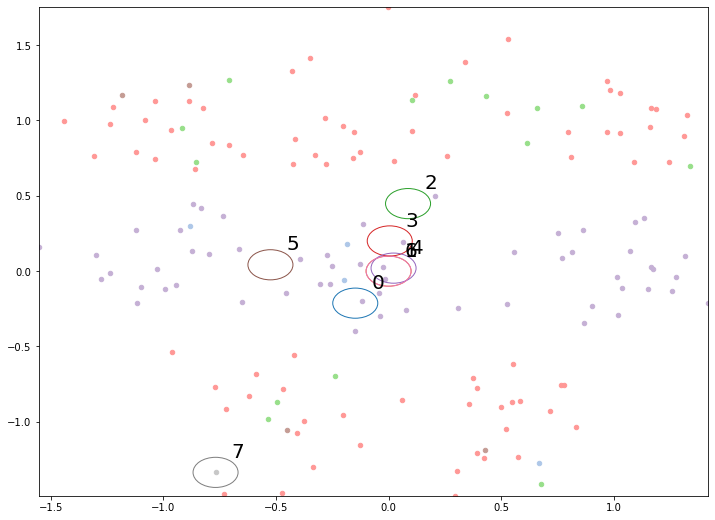

In [100]:
rf = get_hidden_mean_receptive_fields(rtrbm.W.cpu(), torch.tensor(neuron_coordinates), only_max_conn=True)

create_plot(rtrbm.W.cpu(), rtrbm.W_acc.cpu(), torch.nan_to_num(rf), 
            torch.tensor(neuron_coordinates), 0, dx=0, markersize_visibles=20, 
            hiddens_radius=.1, weight_line_factor=0, hidden_weight_thresh=1.5)


In [84]:
from tqdm.notebook import tqdm


n_epochs = 1000
n_batches = 100
N_V = 160
T = 50
N_H = 8


rtrbm = RTRBM(data_batches, N_H=N_H, device='cpu')

W = torch.zeros(N_H, N_V)
W_acc = torch.zeros(N_H, N_H)
dW_mean = torch.zeros(n_epochs)
dW_acc_mean = torch.zeros(n_epochs)
dW_std = torch.zeros(n_epochs)
dW_acc_std = torch.zeros(n_epochs)
v_contribution_r = torch.zeros(n_epochs, N_H)
h_contribution_r = torch.zeros(n_epochs, N_H)
v_contribution_p = torch.zeros(n_epochs, N_H)
h_contribution_p = torch.zeros(n_epochs, N_H)
bias = torch.zeros(n_epochs, N_H)
v_infer = torch.zeros(n_epochs, N_V, T, n_batches)
r_infer = torch.zeros(n_epochs, N_H, T, n_batches)
r = torch.zeros(n_epochs, N_H, T, n_batches)

dW = torch.zeros(n_epochs, N_H, N_V)
dW_acc = torch.zeros(n_epochs, N_H, N_H)
db_H = torch.zeros(n_epochs, N_H)
db_V = torch.zeros(n_epochs, N_V)
db_init = torch.zeros(n_epochs, N_H)
v_rec_error = torch.zeros(n_epochs)
r_rec_error = torch.zeros(n_epochs)
errors = []
W = torch.zeros(n_epochs, N_H, N_V)
W_acc = torch.zeros(n_epochs, N_H, N_H)

for epoch in tqdm(range(n_epochs)):
    
    rtrbm.learn(n_epochs=1, batchsize=10, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0, disable_tqdm=True)
    
    dW[epoch :, :], dW_acc[epoch, :, :], db_H[epoch, :], db_V[epoch, :], db_init[epoch, :] = rtrbm.dparams
        

    rt = torch.zeros(rtrbm.N_H, rtrbm.T, dtype=torch.float)
    rt[:, 0] = torch.sigmoid(torch.matmul(rtrbm.W, data_batches[:, 0, 0]) + rtrbm.b_init)
    v_contribution_r += torch.mean(torch.matmul(rtrbm.W, data_batches[:, 0, 0]))
    bias[epoch, :] = rtrbm.b_init
    for t in range(1, rtrbm.T):
        rt[:, t] = torch.sigmoid(torch.matmul(rtrbm.W, data_batches[:, t, 0]) + rtrbm.b_H + torch.matmul(rtrbm.W_acc, rt[:, t - 1]))
        v_contribution_r[epoch, :] += torch.matmul(rtrbm.W, data_batches[:, t, 0])
        h_contribution_r[epoch, :] += torch.matmul(rtrbm.W_acc, rt[:, t - 1])
        bias[epoch, :] += torch.squeeze(rtrbm.b_H)
        
    errors += rtrbm.errors
    
    for batch in range(n_batches):
        v_infer[epoch, :, :, batch], r_infer[epoch, :, :, batch] = rtrbm.infer(data_batches[:, :8, batch], mode=2, pre_gibbs_k=20, gibbs_k=10, disable_tqdm=True)
        r[epoch, :, :, batch] = rtrbm.visible_to_expected_hidden(data_batches[:, :, batch])

    
    W[epoch, :, :] = rtrbm.W
    W_acc[epoch, :, :] = rtrbm.W_acc

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
r_infer[epoch, :, :, :].shape

torch.Size([10, 32, 100])

In [35]:
v_infer[epoch, :, :, :].shape

torch.Size([20, 32, 100])

In [71]:
v_inf_mean.shape

torch.Size([1000, 180])

/home/casperpeters/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/casperpeters/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order

Text(0.5, 0, 'epochs')

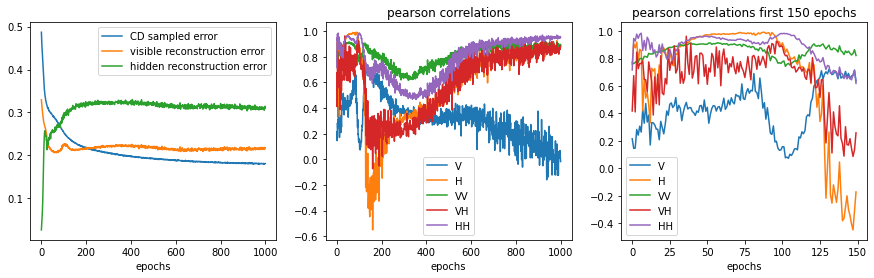

In [87]:
epochs = torch.arange(n_epochs, dtype=torch.float)


v_inf_mean = torch.mean(v_infer[:, :, 9:, :], (2, 3))
r_inf_mean = torch.mean(r_infer[:, :, 9:, :], (2, 3))
r_mean = torch.mean(r[:, :, 9:, :], (2, 3))
v_mean = torch.mean(data_batches[:, 9:, :], (1, 2))
v_mean_error = torch.zeros(n_epochs)
r_mean_error = torch.zeros(n_epochs)
r_V = torch.zeros(n_epochs)
r_H = torch.zeros(n_epochs)
r_VV = torch.zeros(n_epochs)
r_VH = torch.zeros(n_epochs)
r_HH = torch.zeros(n_epochs)

for epoch in range(n_epochs):
    means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, \
           pw_VV_samples, pw_HH_data, pw_HH_samples, pw_VH_data, pw_VH_samples, \
           r_V[epoch], r_H[epoch], r_VV[epoch], r_VH[epoch], r_HH[epoch] = moments(data_batches.reshape(N_V, T*n_batches), 
                                                r[epoch, :, :, :].reshape(N_H, T*n_batches), 
                                                v_infer[epoch, :, :, :].reshape(N_V, T*n_batches), 
                                                r_infer[epoch, :, :, :].reshape(N_H, T*n_batches))
    v_mean_error[epoch] = mse(v_mean, v_inf_mean[epoch, :])
    r_mean_error[epoch] = mse(r_mean[epoch, :], r_inf_mean[epoch, :])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(epochs, errors)
axes[0].plot(epochs, v_rec_error)
axes[0].plot(epochs, r_rec_error)
axes[0].legend(['CD sampled error', 'visible reconstruction error', 'hidden reconstruction error'])
axes[0].set_xlabel('epochs')

axes[1].plot(epochs, r_V)
axes[1].plot(epochs, r_H)
axes[1].plot(epochs, r_VV)
axes[1].plot(epochs, r_VH)
axes[1].plot(epochs, r_HH)
axes[1].set_title('pearson correlations')
axes[1].legend(['V', 'H', 'VV', 'VH', 'HH'])
axes[1].set_xlabel('epochs')

axes[2].plot(epochs[:150], r_V[:150])
axes[2].plot(epochs[:150], r_H[:150])
axes[2].plot(epochs[:150], r_VV[:150])
axes[2].plot(epochs[:150], r_VH[:150])
axes[2].plot(epochs[:150], r_HH[:150])
axes[2].set_title('pearson correlations first 150 epochs')
axes[2].legend(['V', 'H', 'VV', 'VH', 'HH'])
axes[2].set_xlabel('epochs')

### Reconstruction first 100 epochs

Text(0.5, 1.0, "$W'$")

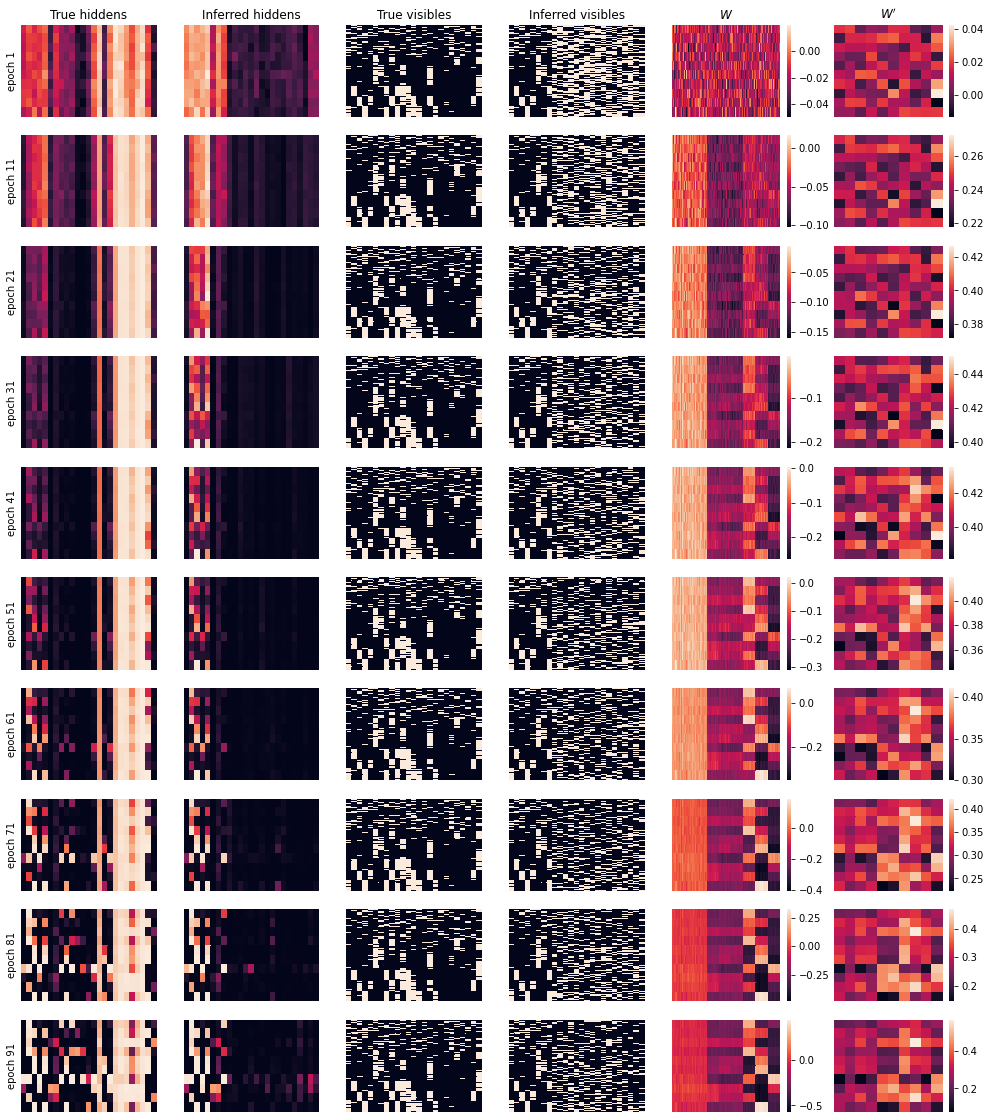

In [79]:
sample = 0
fig, axes = plt.subplots(10, 6, figsize=(17,20))
for i, ax in enumerate(axes):
    sns.heatmap(r[10*i, :, :, sample], ax=ax[0], cbar=False)
    sns.heatmap(r_infer[10*i, :, :, sample], ax=ax[1], cbar=False)
    sns.heatmap(data_batches[:, :, sample], ax=ax[2], cbar=False)
    sns.heatmap(v_infer[10*i, :, :, sample], ax=ax[3], cbar=False)
    sns.heatmap(W[10*i, :, :], ax=ax[4], cbar=True)
    sns.heatmap(W_acc[10*i, :, :], ax=ax[5], cbar=True)
    ax[0].set_ylabel('epoch '+ str(10*i + 1))
    for x in ax: 
        x.set_xticks([])
        x.set_yticks([])
        
axes[0, 0].set_title('True hiddens')
axes[0, 1].set_title('Inferred hiddens')
axes[0, 2].set_title('True visibles')
axes[0, 3].set_title('Inferred visibles')
axes[0, 4].set_title('$W$')
axes[0, 5].set_title('$W\'$')

### Reconstruction every 100 epochs

Text(0.5, 1.0, "$W'$")

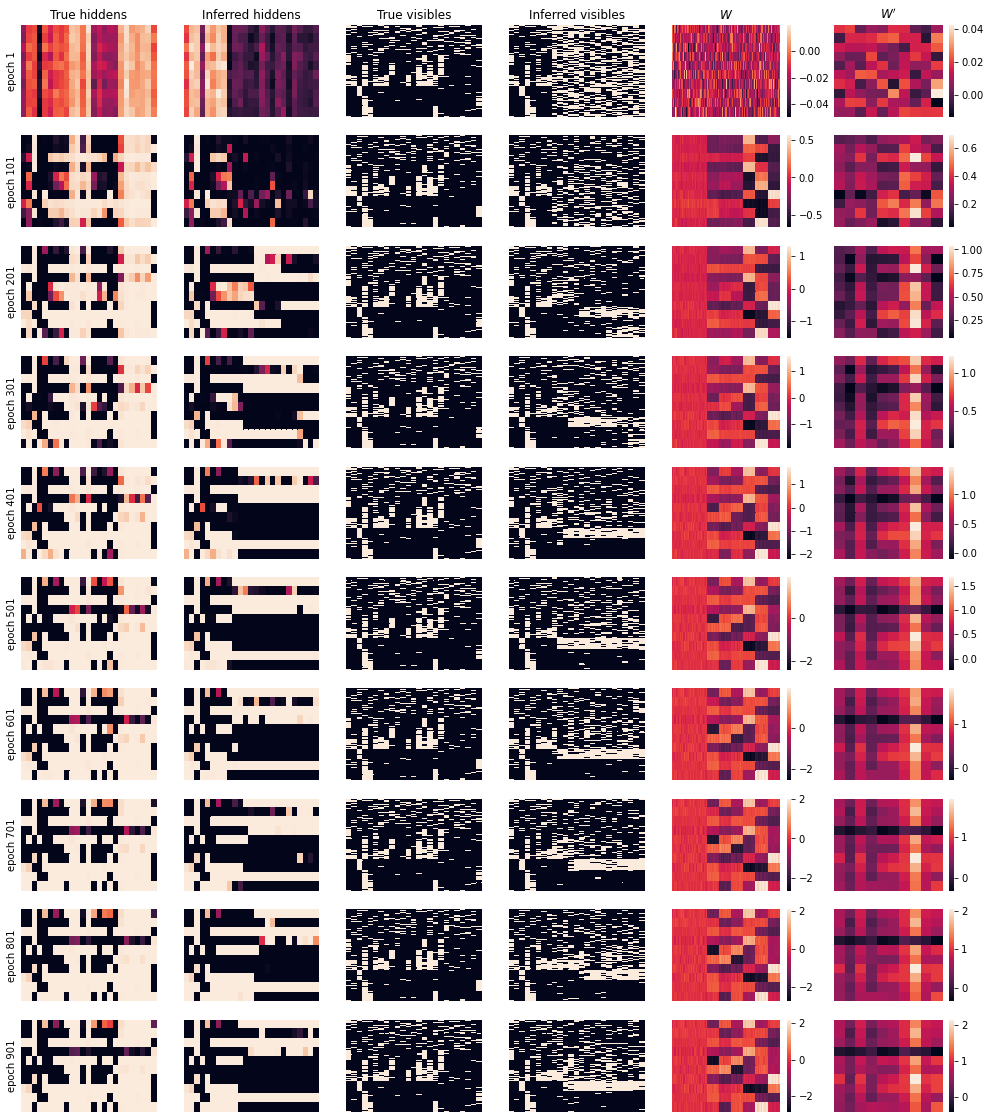

In [82]:
sample = 5
fig, axes = plt.subplots(10, 6, figsize=(17,20))
for i, ax in enumerate(axes):
    sns.heatmap(r[i*100, :, :, sample], ax=ax[0], cbar=False)
    sns.heatmap(r_infer[i*100, :, :, sample], ax=ax[1], cbar=False)
    sns.heatmap(data_batches[:, :, sample], ax=ax[2], cbar=False)
    sns.heatmap(v_infer[i*100, :, :, sample], ax=ax[3], cbar=False)
    sns.heatmap(W[i*100, :, :], ax=ax[4], cbar=True)
    sns.heatmap(W_acc[i*100, :, :], ax=ax[5], cbar=True)
    ax[0].set_ylabel('epoch '+ str(i*100 + 1))
    for x in ax: 
        x.set_xticks([])
        x.set_yticks([])
        
axes[0, 0].set_title('True hiddens')
axes[0, 1].set_title('Inferred hiddens')
axes[0, 2].set_title('True visibles')
axes[0, 3].set_title('Inferred visibles')
axes[0, 4].set_title('$W$')
axes[0, 5].set_title('$W\'$')

There seems to be a sweet spot between 40 and 50 epochs

### Reconstruction epoch 100 - 200

Text(0.5, 1.0, "$W'$")

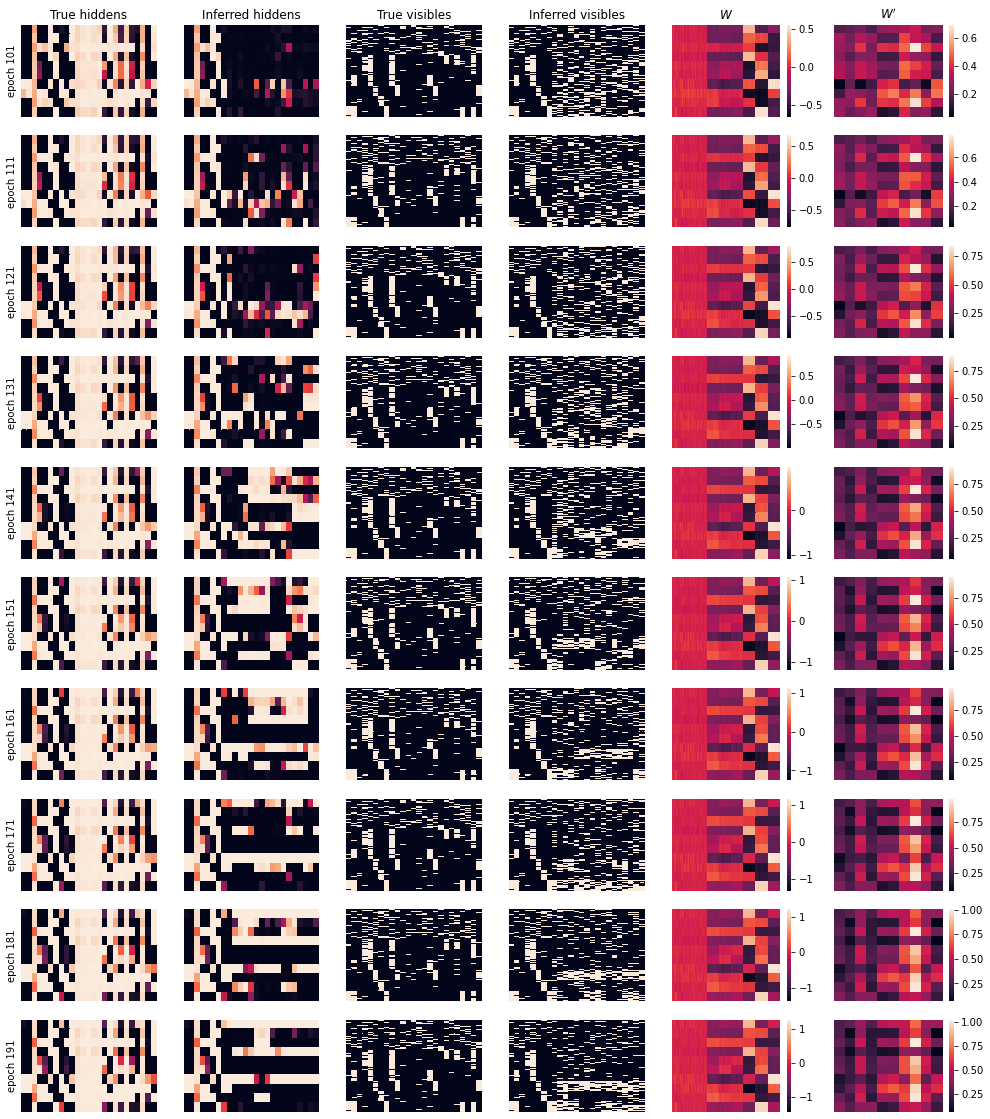

In [66]:
sample = 1
fig, axes = plt.subplots(10, 6, figsize=(17,20))
for i, ax in enumerate(axes):
    sns.heatmap(r[100+10*i, :, :, sample], ax=ax[0], cbar=False)
    sns.heatmap(r_infer[100+10*i, :, :, sample], ax=ax[1], cbar=False)
    sns.heatmap(data_batches[:, :, sample], ax=ax[2], cbar=False)
    sns.heatmap(v_infer[100+10*i, :, :, sample], ax=ax[3], cbar=False)
    sns.heatmap(W[100+10*i, :, :], ax=ax[4], cbar=True)
    sns.heatmap(W_acc[100+10*i, :, :], ax=ax[5], cbar=True)
    ax[0].set_ylabel('epoch '+ str(100+10*i + 1))
    for x in ax: 
        x.set_xticks([])
        x.set_yticks([])
        
axes[0, 0].set_title('True hiddens')
axes[0, 1].set_title('Inferred hiddens')
axes[0, 2].set_title('True visibles')
axes[0, 3].set_title('Inferred visibles')
axes[0, 4].set_title('$W$')
axes[0, 5].set_title('$W\'$')

### Relative contributions of terms to hidden units

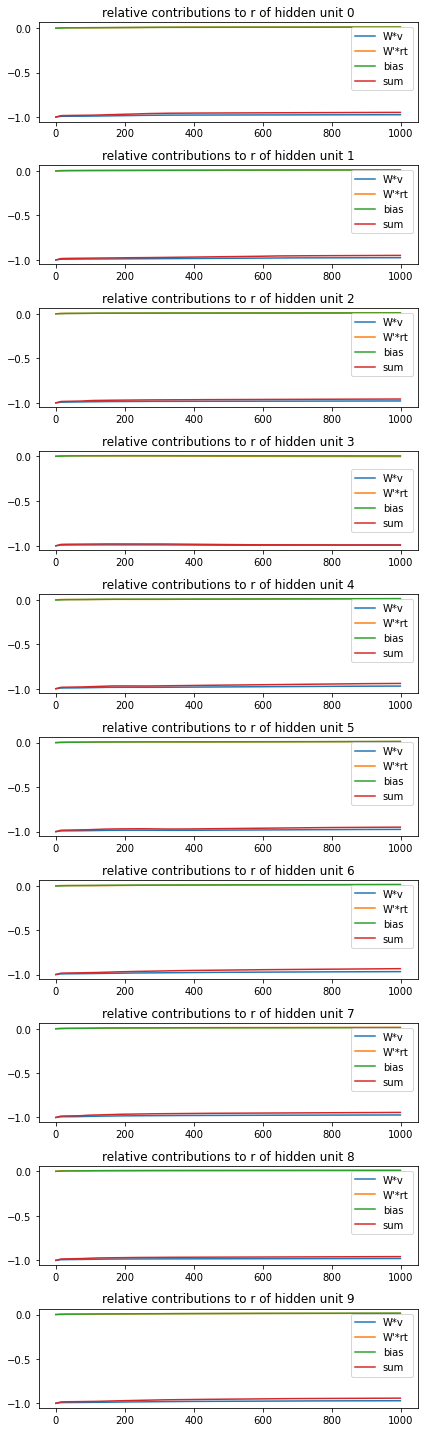

In [67]:
fig, axes = plt.subplots(10, 1, figsize=(6, 20))
epochs = torch.arange(n_epochs)
for i, ax in enumerate(axes):
    tot = torch.abs(v_contribution_r[:, i]) + torch.abs(h_contribution_r[:, i]) + torch.abs(bias[:, i])
    ax.plot(epochs, v_contribution_r[:, i] / tot)
    ax.plot(epochs, h_contribution_r[:, i] / tot)
    ax.plot(epochs, bias[:, i] / tot)
    ax.plot(epochs, (v_contribution_r[:, i] + h_contribution_r[:, i] + bias[:, i]) / tot)
    ax.set_title('relative contributions to r of hidden unit ' + str(i))
    ax.legend(['W*v', 'W\'*rt', 'bias', 'sum'])
    
plt.tight_layout()

### plotting the means of gradient updates

Text(0.5, 1.0, '$db_{init}$')

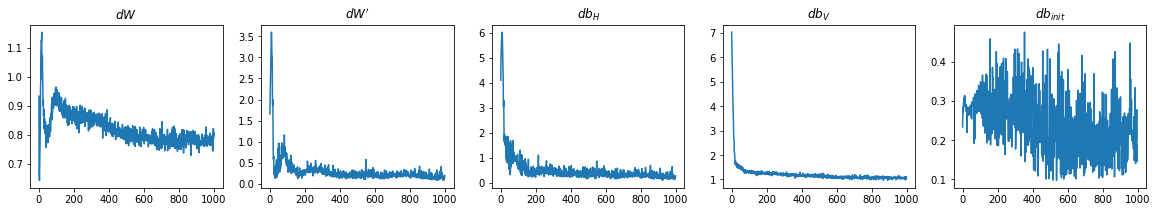

In [68]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
ax[0].plot(torch.mean(torch.abs(dW), (1, 2)))
ax[0].set_title('$dW$')
ax[1].plot(torch.mean(torch.abs(dW_acc), (1, 2)))
ax[1].set_title('$dW\'$')
ax[2].plot(torch.mean(torch.abs(db_H), 1))
ax[2].set_title('$db_H$')
ax[3].plot(torch.mean(torch.abs(db_V), 1))
ax[3].set_title('$db_V$')
ax[4].plot(torch.mean(torch.abs(db_init), 1))
ax[4].set_title('$db_{init}$')

### Plotting the standard deviation of the gradient updates

Text(0.5, 1.0, '$db_{init}$')

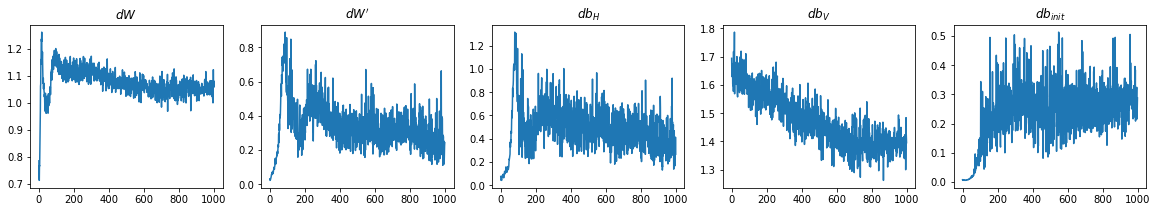

In [69]:
fig, ax = plt.subplots(1, 5, figsize=(20,3))
ax[0].plot(torch.std(dW, (1, 2)))
ax[0].set_title('$dW$')
ax[1].plot(torch.std(dW_acc, (1, 2)))
ax[1].set_title('$dW\'$')
ax[2].plot(torch.std(db_H, 1))
ax[2].set_title('$db_H$')
ax[3].plot(torch.std(db_V, 1))
ax[3].set_title('$db_V$')
ax[4].plot(torch.std(db_init, 1))
ax[4].set_title('$db_{init}$')